In [103]:
!pip install gender-guesser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 KB 8.8 MB/s eta 0:00:00


In [18]:
!pip install numpy
!pip install scipy
!pip install pybrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
!pip uninstall h5py
!pip install h5py==2.10.0

Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/h5py-3.1.0.dist-info/*
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libaec-9c9e97eb.so.0.0.10
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libhdf5-00e8fae8.so.200.0.0
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libhdf5_hl-383c339f.so.200.0.0
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libsz-e7aa62f5.so.2.0.1
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.8/dist-packages/h5py/*
Proceed (Y/n)? y
  Successfully uninstalled h5py-3.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 42.5 MB/s eta 0:00:00


In [92]:
import sys
import csv
import os
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import sexmachine.detector as gender
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
#from sklearn import cross_validation
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from  sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
#from sklearn.learning_curve import learning_curve
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import roc_curve, auc ,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline 

In [120]:
from sklearn.svm import SVC

In [94]:
def read_datasets():
    """ Reads users profile from csv files """
    genuine_users = pd.read_csv("/content/drive/MyDrive/FakeProfile/users.csv")
    fake_users = pd.read_csv("/content/drive/MyDrive/FakeProfile/fusers.csv")
    print (genuine_users.columns)
    print (genuine_users.describe())
    print (fake_users.describe())
    x=pd.concat([genuine_users,fake_users])   
    y=len(fake_users)*[0] + len(genuine_users)*[1]
    return x,y

In [104]:
import gender_guesser.detector as gender

def predict_sex(name):
    sex_predictor = gender.Detector(case_sensitive=False)
    first_name = name.str.split(' ').str.get(0)
    sex = first_name.apply(sex_predictor.get_gender)
    sex_dict = {'female': -2, 'mostly_female': -1, 'andy': 0, 'unknown': 0, 'mostly_male': 1, 'male': 2}
    sex_code = sex.map(sex_dict).astype(int)
    return sex_code

In [105]:
def extract_features(x):
    lang_list = list(enumerate(np.unique(x['lang'])))   
    lang_dict = { name : i for i, name in lang_list }             
    x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)    
    x.loc[:,'sex_code'] = predict_sex(x['name'])
    feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','sex_code','lang_code']
    x = x.loc[:,feature_columns_to_use]
    return x

In [106]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [107]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    target_names=['Fake','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [108]:
def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print ("False Positive rate: ",false_positive_rate)
    print ("True Positive rate: ",true_positive_rate)
    
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [131]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

In [132]:
def train(X_train,y_train,X_test):
    """ Trains and predicts dataset with a SVM classifier """
    # Scaling features
    X_train=preprocessing.scale(X_train)
    X_test=preprocessing.scale(X_test)

    Cs = 10.0 ** np.arange(-2,3,.5)
    gammas = 10.0 ** np.arange(-2,3,.5)
    param = [{'gamma': gammas, 'C': Cs}]
    cvk = StratifiedKFold(n_splits=5, shuffle=True)
    classifier = SVC()
    clf = GridSearchCV(classifier,param_grid=param,cv=cvk)
    clf.fit(X_train,y_train)
    print("The best classifier is: ",clf.best_estimator_)
    clf.best_estimator_.fit(X_train,y_train)
    # Estimate score
    scores = model_selection.cross_val_score(clf.best_estimator_, X_train,y_train, cv=5)
    print (scores)
    print('Estimated score: %0.5f (+/- %0.5f)' % (scores.mean(), scores.std() / 2))
    title = 'Learning Curves (SVM, rbf kernel, )' %clf.best_estimator_.gamma
    plot_learning_curve(clf.best_estimator_, title, X_train, y_train, cv=5)
    plt.show()
    # Predict class
    y_pred = clf.best_estimator_.predict(X_test)
    return y_test,y_pred

In [133]:
print ("reading datasets.....\n")
x,y=read_datasets()

reading datasets.....

Index(['id', 'name', 'screen_name', 'statuses_count', 'followers_count',
       'friends_count', 'favourites_count', 'listed_count', 'created_at',
       'url', 'lang', 'time_zone', 'location', 'default_profile',
       'default_profile_image', 'geo_enabled', 'profile_image_url',
       'profile_banner_url', 'profile_use_background_image',
       'profile_background_image_url_https', 'profile_text_color',
       'profile_image_url_https', 'profile_sidebar_border_color',
       'profile_background_tile', 'profile_sidebar_fill_color',
       'profile_background_image_url', 'profile_background_color',
       'profile_link_color', 'utc_offset', 'protected', 'verified',
       'description', 'updated', 'dataset'],
      dtype='object')
                 id  statuses_count  followers_count  friends_count  \
count  1.481000e+03     1481.000000      1481.000000    1481.000000   
mean   4.000432e+08     3140.782579       690.922350     403.128292   
std    2.961304e+08    

In [111]:
print ("extracting featues.....\n")
x=(extract_features(x))

extracting featues.....



In [112]:
print (x.columns)
print (x.describe())

Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'sex_code', 'lang_code'],
      dtype='object')
       statuses_count  followers_count  friends_count  favourites_count  \
count     2818.000000      2818.000000    2818.000000       2818.000000   
mean      1672.198368       371.105039     395.363023        234.541164   
std       4884.669157      8022.631339     465.694322       1445.847248   
min          0.000000         0.000000       0.000000          0.000000   
25%         35.000000        17.000000     168.000000          0.000000   
50%         77.000000        26.000000     306.000000          0.000000   
75%       1087.750000       111.000000     519.000000         37.000000   
max      79876.000000    408372.000000   12773.000000      44349.000000   

       listed_count     sex_code    lang_code  
count   2818.000000  2818.000000  2818.000000  
mean       2.818666    -0.191270     2.851313  
std       23.480430     1.68

In [113]:
print ("spliting datasets in train and test dataset...\n")
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size=0.20, random_state=44)

spliting datasets in train and test dataset...



In [115]:
from sklearn.model_selection import StratifiedKFold

training datasets.......

The best classifier is:  SVC(gamma=31.622776601683793)
[0.91796009 0.92904656 0.92461197 0.9556541  0.93777778]
Estimated score: 0.93301 (+/- 0.00651)


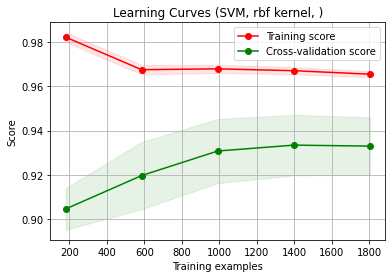

In [134]:
print ("training datasets.......\n")
y_test,y_pred = train(X_train,y_train,X_test)

In [136]:
print ('Classification Accuracy on Test dataset: ' ,accuracy_score(y_test, y_pred))

Classification Accuracy on Test dataset:  0.9024822695035462


Confusion matrix, without normalization
[[262   6]
 [ 49 247]]


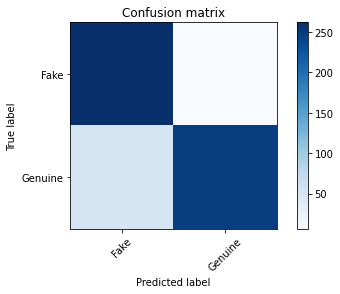

In [137]:
cm=confusion_matrix(y_test, y_pred)
print('Confusion matrix, without normalization')
print(cm)
plot_confusion_matrix(cm)

Normalized confusion matrix
[[0.97761194 0.02238806]
 [0.16554054 0.83445946]]


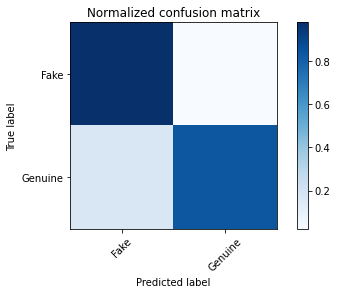

In [138]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

In [139]:
print(classification_report(y_test, y_pred, target_names=['Fake','Genuine']))

              precision    recall  f1-score   support

        Fake       0.84      0.98      0.91       268
     Genuine       0.98      0.83      0.90       296

    accuracy                           0.90       564
   macro avg       0.91      0.91      0.90       564
weighted avg       0.91      0.90      0.90       564



False Positive rate:  [0.         0.02238806 1.        ]
True Positive rate:  [0.         0.83445946 1.        ]


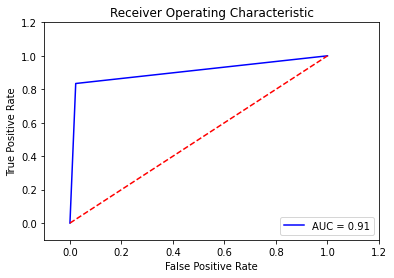

In [140]:
plot_roc_curve(y_test, y_pred)

Random Forest

In [143]:
def train1(X_train,y_train,X_test):
    """ Trains and predicts dataset with a Random Forest classifier """
    
    clf=RandomForestClassifier(n_estimators=40,oob_score=True)
    clf.fit(X_train,y_train)
    print("The best classifier is: ",clf)
    # Estimate score
    scores = model_selection.cross_val_score(clf, X_train,y_train, cv=5)
    print (scores)
    print('Estimated score: %0.5f (+/- %0.5f)' % (scores.mean(), scores.std() / 2))
    title = 'Learning Curves (Random Forest)'
    plot_learning_curve(clf, title, X_train, y_train, cv=5)
    plt.show()
    # Predict 
    y_pred = clf.predict(X_test)
    return y_test,y_pred
     

training datasets.......

The best classifier is:  RandomForestClassifier(n_estimators=40, oob_score=True)
[0.93569845 0.93569845 0.94456763 0.9578714  0.94444444]
Estimated score: 0.94366 (+/- 0.00406)


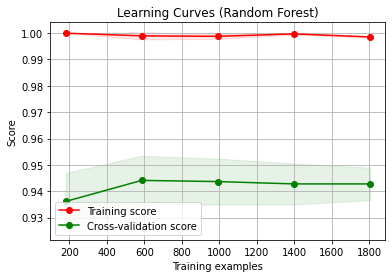

In [146]:
print ("training datasets.......\n")
y_test1,y_pred1 = train1(X_train,y_train,X_test)

In [148]:
print ('Classification Accuracy on Test dataset: ' ,accuracy_score(y_test1, y_pred1))

Classification Accuracy on Test dataset:  0.9450354609929078


Confusion matrix, without normalization
[[266   2]
 [ 29 267]]


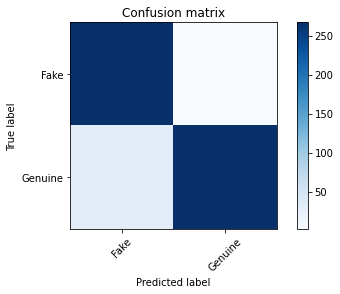

In [150]:
cm1=confusion_matrix(y_test1, y_pred1)
print('Confusion matrix, without normalization')
print(cm1)
plot_confusion_matrix(cm1)

Normalized confusion matrix
[[0.99253731 0.00746269]
 [0.09797297 0.90202703]]


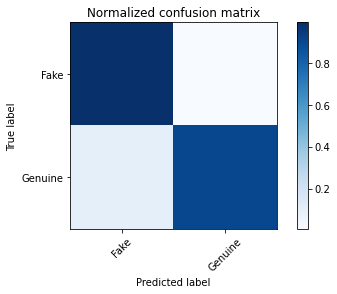

In [151]:
cm_normalized1 = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized1)
plot_confusion_matrix(cm_normalized1, title='Normalized confusion matrix')

In [152]:
print(classification_report(y_test1, y_pred1, target_names=['Fake','Genuine']))

              precision    recall  f1-score   support

        Fake       0.90      0.99      0.94       268
     Genuine       0.99      0.90      0.95       296

    accuracy                           0.95       564
   macro avg       0.95      0.95      0.95       564
weighted avg       0.95      0.95      0.95       564



False Positive rate:  [0.         0.00746269 1.        ]
True Positive rate:  [0.         0.90202703 1.        ]


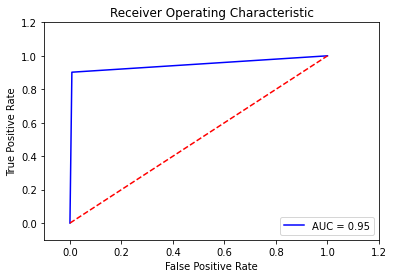

In [153]:
plot_roc_curve(y_test1, y_pred1)



---

